6766592


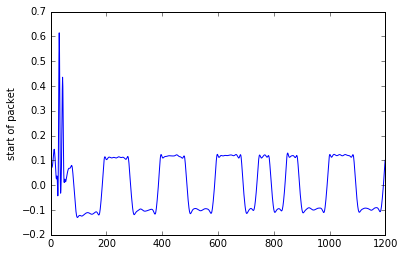

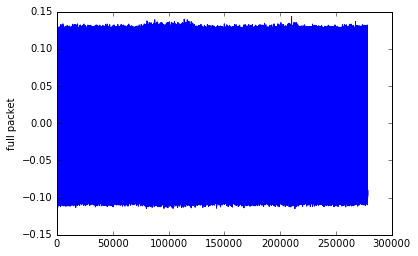

In [114]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile('data.pdm',dtype=np.float32)

print len(samples)

plt.plot(samples[324800:326000])
plt.ylabel('start of packet')
plt.show()

packet_samples = samples[324900:603305]
plt.plot(packet_samples)
plt.ylabel('full packet')
plt.show()



widths = array([100, 102,  99, ...,  53,  98, 103])


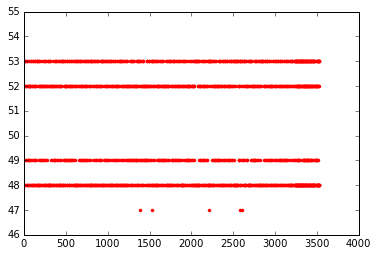

In [146]:
samples = packet_samples
signs = np.array(samples >= 0, int)
differences = np.diff(signs)
#print differences[0:1000]
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
#print crossings
cumulWidths = crossings[1:] - crossings[0]
#print "cumulWidths = %s" % cumulWidths
widths = (cumulWidths[1:] - cumulWidths[:-1])
print "widths = " + repr(widths)
#plt.hist(widths,bins=30,range=[30,60])
#plt.show()
plt.ylim(46,55)
plt.plot(widths,'r.')


